In [ ]:
https://github.com/dathwal/DSCI100-Project.git

First, we load in the necessary libraries.

In [76]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)


options(repr.matrix.max.rows = 6)


The two datasets (players.csv and sessions.csv) are then loaded in using the read_csv function. To help with 
visualizing the column names, the glimpse function is used. 

In [6]:
players<- read_csv("players.csv")

glimpse(players)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…


Figure 1

In [7]:
# loaded Data Set
sessions <- read_csv("sessions.csv")
glimpse(sessions)


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


The question that I wish to answer is predictive, so the method that we will use is classification. We wish to find clusters of data that will hopefully show if there is a particular age group that contributes the most played hours so that we are able to target this age group with advertising. First, tidy the data. 

In [41]:
players_cleaned <- players |>
select(played_hours, experience)|>
mutate(experience = as_factor(experience))
players_cleaned

played_hours,experience
<dbl>,<fct>
30.3,Pro
3.8,Veteran
0.0,Veteran
⋮,⋮
0.0,Amateur
2.3,Amateur
0.2,Pro


Figure 1.2

This cleaned data can now be used to create a plot to observe any relationships between the two variables.

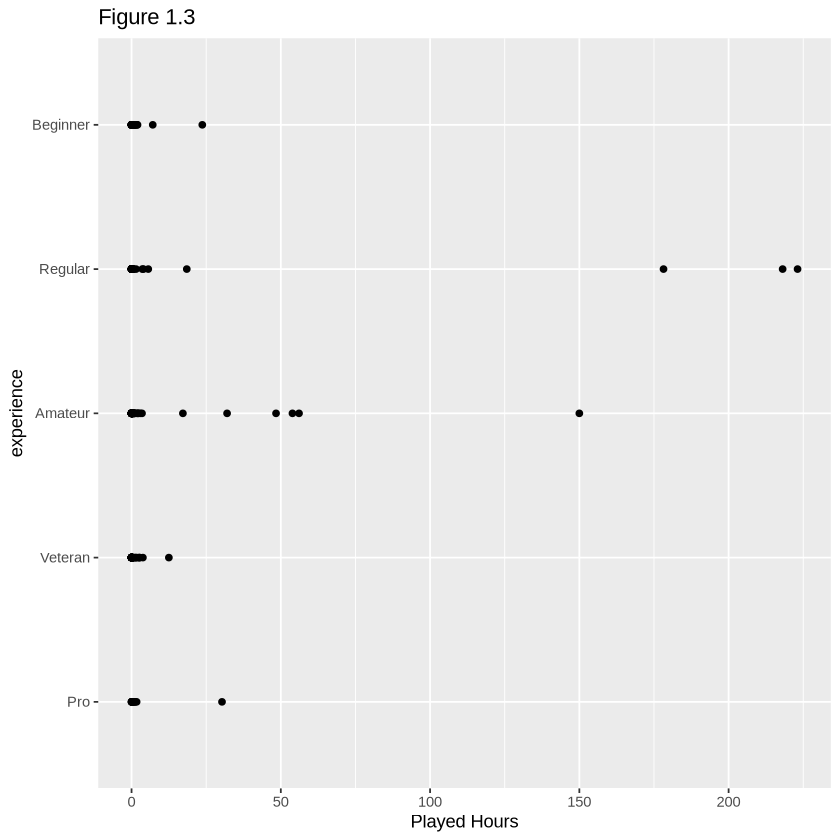

In [192]:
players_plot <- players_cleaned|>
ggplot(aes(x=played_hours, y=experience))+
geom_point() +
ggtitle("Figure 1.3")+
xlab("Played Hours")

players_plot

The dataset can now be split into training and testing sets.

In [186]:
set.seed(1543)
players_split <- initial_split(players_cleaned, prop=0.7,strata=experience)
players_training <- training(players_split)
players_training
players_testing <- testing(players_split)

played_hours,experience
<dbl>,<fct>
0.7,Amateur
0.0,Amateur
0.0,Amateur
⋮,⋮
0.1,Veteran
0.1,Veteran
0.3,Veteran


Figure1.4

A recipe is then created based on the training set.

In [187]:
k_recipe <- recipe(experience ~ played_hours, data = players_training)|>
step_scale(all_numeric())|>
step_center(all_numeric())|>
step_upsample(experience, over_ratio=1)

A KNN classification model and is then tuned and fitted.

In [188]:
k_spec <- nearest_neighbor(weight= "rectangular", neighbors=9)|>
set_engine("kknn")|>
set_mode("classification")

The model and recipe are then fitted with the training data using a workflow.

In [189]:

k_fit <- workflow()|>
add_recipe(k_recipe)|>
add_model(k_spec)|>
fit(data = players_training)

k_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6727273
Best kernel: rectangular
Best k: 9

The fitted model is then evaluated by predicting the classes in the testing set. 

In [190]:
k_predict <- k_fit|>
predict(players_testing)|>
bind_cols(players_testing)|>
metrics(truth=experience, estimate = .pred_class)|>
filter(.metric== "accuracy")
k_predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.09836066


Figure 1.5

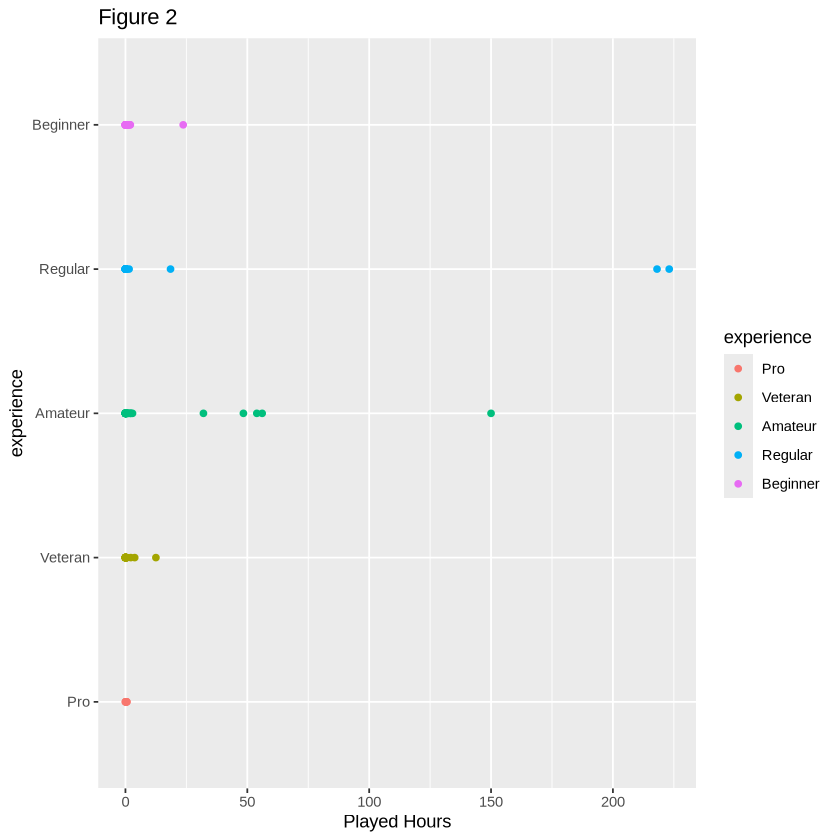

In [191]:
players_graph <- players_training |>
ggplot(aes(y=experience, x=played_hours,colour=experience))+
geom_point()+
ggtitle("Figure 2")+
xlab("Played Hours")

players_graph

Individual Report

A research group at UBC collected data about players of a MineCraft server and aimed to use this information collected to answer different questions relating to player types, playtimes and game-related newsletter subscriptions.The question that I centered this project around was to see if player experience influenced the amount of hours played. This was done in order to see if we can target advertising of this Minecraft server to a specific group of people. The data collected by the research group was split into two data sets; players.csv and sessions.csv. In this project, I utilized the players.csv file since it contained information that could be used to answer my research question. The players.csv file contained 196 observations with variables labelled experience, gender, Age, name, hashedEmail, played_hours and subscribe (Figure 1). These variables were initially in dbl or chr values, however some variable types were modified for use in the KNN Classification model.

Upon loading the players.csv file into R using the read_csv function, I used the select function to wrangle data into the desired format. This was done by selecting the played_hours and experience variables and then mutating the experience variable to be a factored column so that it could later be used in a KNN Classification recipe. This new data set was then visualized in a scatterplot (Figure 1.3) to see if there was any correlation between the two variables. We noticed from this graph that the highest number of hours played was attributed to Regular players. This showed that there was some type of relationship between the two variables and that exploratory data analysis could now take place.

I then split the cleaned players data set into a training and testing set so that we would be able to tune and then evaluate our KNN Classifier. By using the set.seed function I was able to ensure that all results would be reproducible. A KNN recipe was then created based on the training data set, it was designed to predict the experience level of a player based on the hours they spend playing on the server. The recipe was scaled and centered accordingly during this step. KNN Classification was appropriate in this case since we wished to assign factored classes to any new observations based on the collected values of our training set. However, we did have to assume that the labels within the experience variable were correctly assigned since we do not have any input into how these values were assigned and determined for the data set. A KNN model was also created to specify that we wished to use KNN Classification. The recipe and model were then fitted in a workflow and were used to predict classes on the previously created training set. I was then able to gather the metrics from this prediction which allowed me to see the accuracy of the classifier(Figure 1.5).

The accuracy metric recieved from predicting the experience labels of the test value gave an extremely low accuracy estimate meaning that my classifier would need to be seriously modified in order to yield useful results. These findings helped me to understand that a better model specification would perhaps use more of the predictor variables found in the data set and that tuning to find the best value of K nearest neighbors would be a good way to improve the classifier. These findings suggest that player experience likely does not have as much of an impact on determining played_hours as was previously thought.